<a href="https://colab.research.google.com/github/hernanullon/SynteticLoadCurves/blob/main/notebooks/main_projeto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importo bibliotecas

In [2]:
#! -*- coding: utf-8 -*-
# Keras implement of NICE (Non-linear Independent Components Estimation)
# https://arxiv.org/abs/1410.8516

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from numpy import genfromtxt
from sklearn.preprocessing import MinMaxScaler

Visualização dos dados de todos os transformadores

1000346.csv (474, 97)
(473, 96)


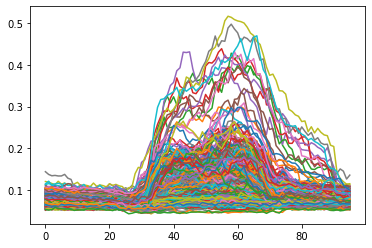

1000169.csv (422, 97)
(421, 96)


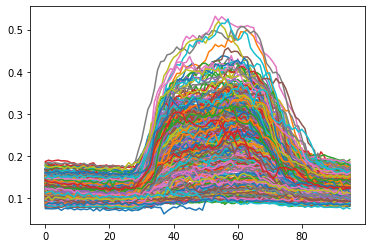

0000107.csv (365, 97)
(364, 96)


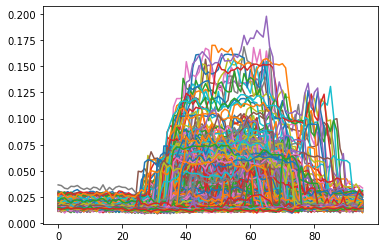

0000106.csv (97,)
1000501.csv (395, 97)
(394, 96)


<Figure size 432x288 with 0 Axes>

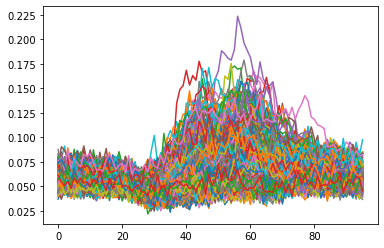

1000560.csv (393, 97)
(392, 96)


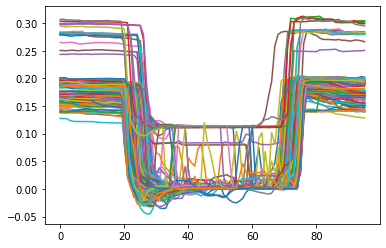

1000561.csv (388, 97)
(387, 96)


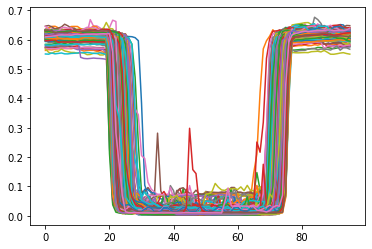

1000192.csv (101, 97)
(100, 96)


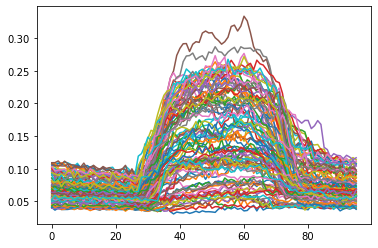

0000176.csv (103, 97)
(102, 96)


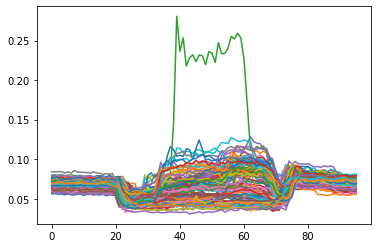

1000187.csv (497, 97)
(496, 96)


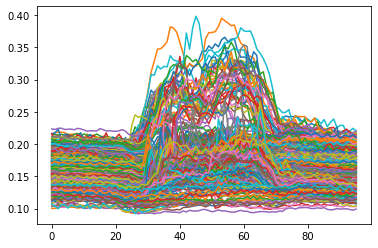

1000526.csv (421, 97)
(420, 96)


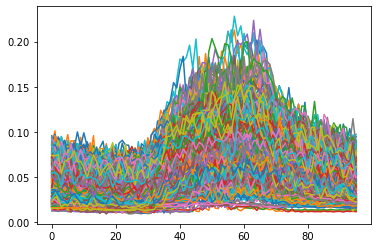

0000100.csv (25, 97)
(24, 96)


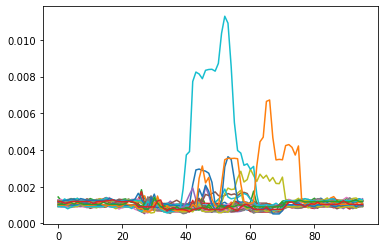

1000557.csv (365, 97)
(364, 96)


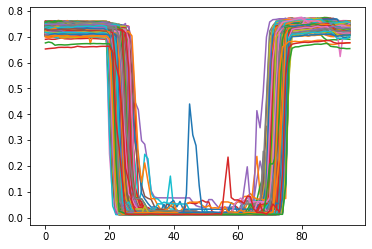

1000525.csv (55, 97)
(54, 96)


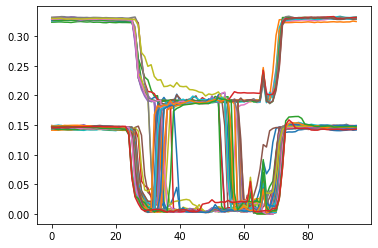

1000343.csv (15, 97)
(14, 96)


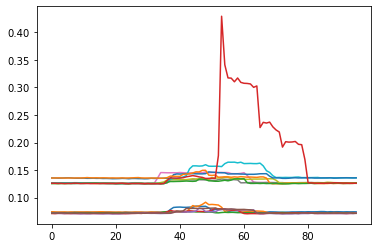

0000124.csv (417, 97)
(416, 96)


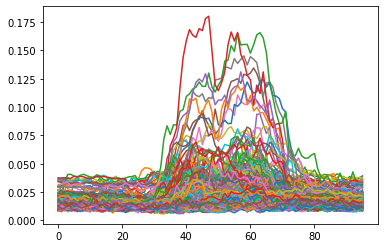

1000259.csv (121, 97)
(120, 96)


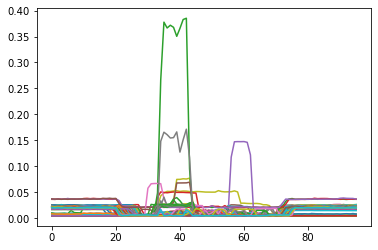

1000142.csv (436, 97)
(435, 96)


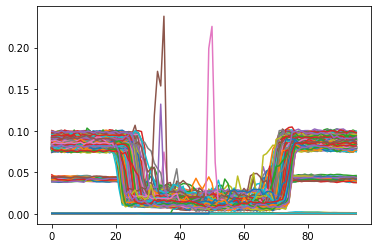

0000131.csv (271, 97)
(270, 96)


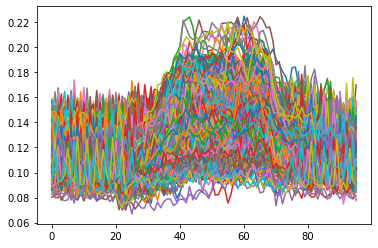

1000170.csv (359, 97)
(358, 96)


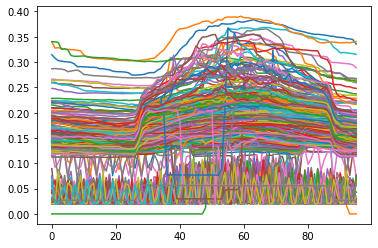

1000186.csv (23, 97)
(22, 96)


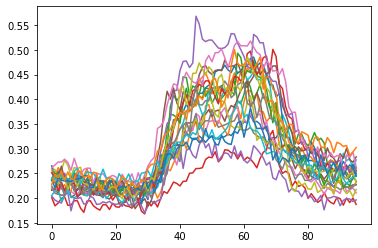

0000142.csv (494, 97)
(493, 96)


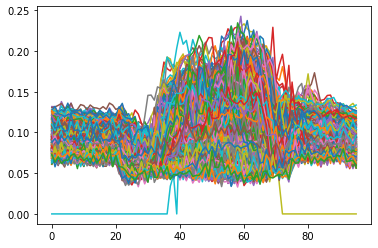

1000184.csv (497, 97)
(496, 96)


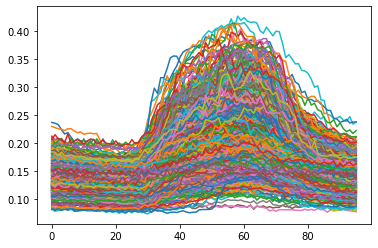

0000102.csv (19, 97)
(18, 96)


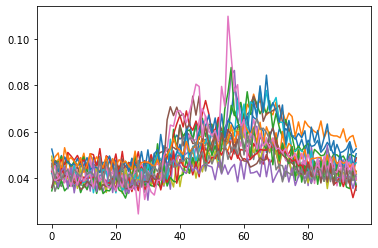

1000556.csv (399, 97)
(398, 96)


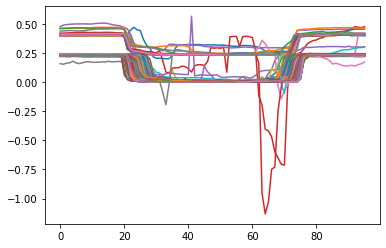

0000152.csv (493, 97)
(492, 96)


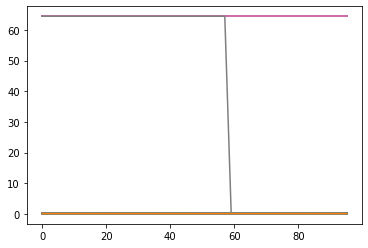

1000584.csv (132, 97)
(131, 96)


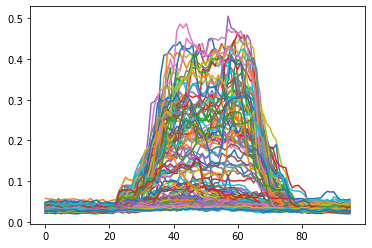

1000131.csv (498, 97)
(497, 96)


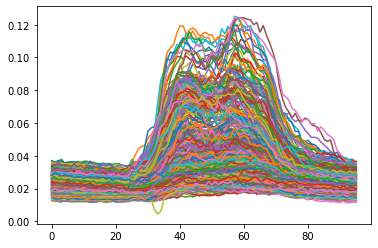

0000157.csv (488, 97)
(487, 96)


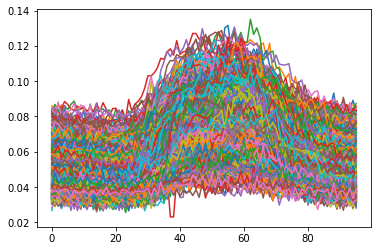

0000114.csv (377, 97)
(376, 96)


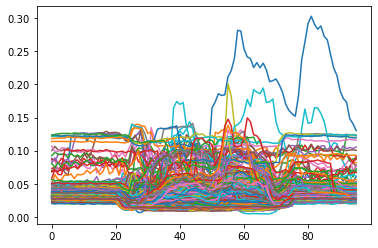

0000162.csv (232, 97)
(231, 96)


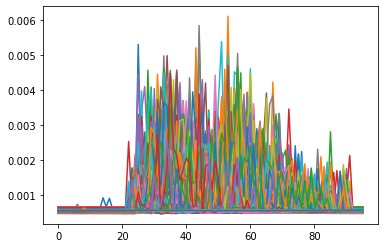

0000178.csv (97,)
1000587.csv (293, 97)
(292, 96)


<Figure size 432x288 with 0 Axes>

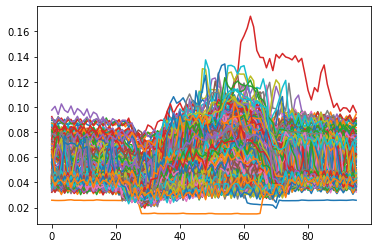

1000191.csv (448, 97)
(447, 96)


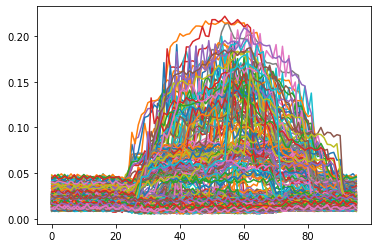

1000146.csv (230, 97)
(229, 96)


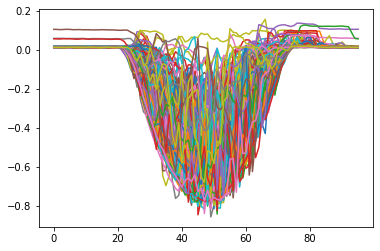

1000145.csv (378, 97)
(377, 96)


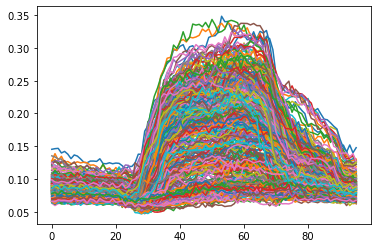

0000140.csv (447, 97)
(446, 96)


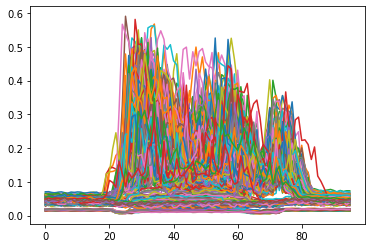

0000116.csv (219, 97)
(218, 96)


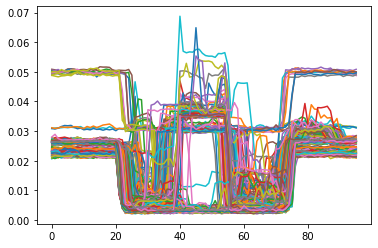

1000172.csv (471, 97)
(470, 96)


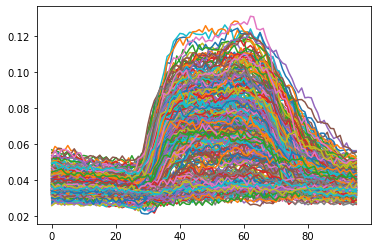

1001194.csv (351, 97)
(350, 96)


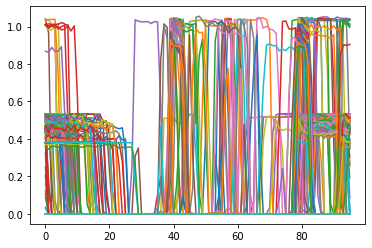

In [56]:
_dir = "/home/lab_acustica/IA367/Project/uteis/"

prova = ['0000100.csv', '0000102.csv', '0000106.csv','0000107.csv','0000114.csv','0000116.csv','0000124.csv','0000131.csv','0000140.csv','0000142.csv','0000152.csv']
gmu = ["1000346", "1000169"]
lojas = ["0000107", "0000106"]

data_list = np.zeros((1,96))
scaler = MinMaxScaler()

for filename in os.listdir(_dir):
#  if filename in prova:
  plt.figure()
  my_data = genfromtxt(os.path.join(_dir, filename), delimiter=',')
  print(filename, my_data.shape)
  if len(my_data.shape) == 2:
    my_data = my_data[1:,1:]
    #my_data = scaler.fit_transform(my_data)
    print(my_data.shape)
    for i in range(my_data.shape[0]):
      plt.plot(my_data[i])
    plt.show()  

Seleciono o transformador com melhor comportamento

file 1000172.csv (471, 97)


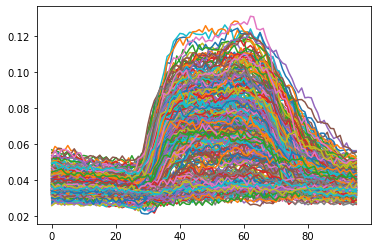

(470, 96)


In [70]:
_dir = "/home/lab_acustica/IA367/Project/uteis/"

prova = ['1000172.csv']

data_list = np.zeros((1,96))
scaler = MinMaxScaler()

for filename in os.listdir(_dir):
  if filename in prova:
    my_data = genfromtxt(os.path.join(_dir, filename), delimiter=',')
    print('file',filename, my_data.shape)
    if len(my_data.shape) == 2:
      my_data = my_data[1:,1:] 
      my_data_n = scaler.fit_transform(my_data)
    for i in range(my_data.shape[0]):
      plt.plot(my_data[i])
    plt.show()  
    
print(my_data.shape)   

É melhor não usar os dados normalizados

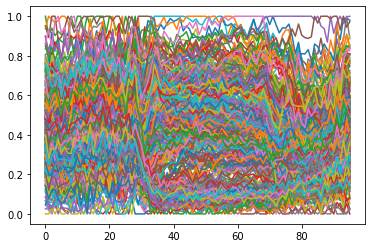

In [71]:
for i in range(my_data_n.shape[0]):
  plt.plot(my_data_n[i])
plt.show()  

In [73]:
# separo em treino e teste
x_train = my_data[:400]
x_test = my_data[400:]
print('dados treino e teste -->',x_train.shape, x_test.shape)

dados treino e teste --> (400, 96) (70, 96)


In [76]:
class Shuffle(Layer):
    """打乱层，提供两种方式打乱输入维度
    一种是直接反转，一种是随机打乱，默认是直接反转维度
    """
    #A camada de embaralhamento fornece duas maneiras de embaralhar a dimensão de entrada:
    #Um é inversão direta, o outro é aleatório, o padrão é inverter diretamente a dimensão
    
    def __init__(self, idxs=None, mode='reverse', **kwargs):
        super(Shuffle, self).__init__(**kwargs)
        self.idxs = idxs
        self.mode = mode
    def call(self, inputs):
        v_dim = K.int_shape(inputs)[-1]
        if self.idxs == None:
            self.idxs = list(range(v_dim))
            if self.mode == 'reverse':
                self.idxs = self.idxs[::-1]
            elif self.mode == 'random':
                np.random.shuffle(self.idxs)
        inputs = K.transpose(inputs)
        outputs = K.gather(inputs, self.idxs)
        outputs = K.transpose(outputs)
        return outputs
    def inverse(self):
        v_dim = len(self.idxs)
        _ = sorted(zip(range(v_dim), self.idxs), key=lambda s: s[1])
        reverse_idxs = [i[0] for i in _]
        return Shuffle(reverse_idxs)


class SplitVector(Layer):
    """将输入分区为两部分，交错分区
    """
    #Particionar a entrada em duas partes, intercalar as partições
    def __init__(self, **kwargs):
        super(SplitVector, self).__init__(**kwargs)
    def call(self, inputs):
        v_dim = K.int_shape(inputs)[-1]
        inputs = K.reshape(inputs, (-1, v_dim//2, 2))
        return [inputs[:,:,0], inputs[:,:,1]]
    def compute_output_shape(self, input_shape):
        v_dim = input_shape[-1]
        return [(None, v_dim//2), (None, v_dim//2)]
    def inverse(self):
        layer = ConcatVector()
        return layer


class ConcatVector(Layer):
    """将分区的两部分重新合并
    """#Mescle novamente as duas partes da partição
    def __init__(self, **kwargs):
        super(ConcatVector, self).__init__(**kwargs)
    def call(self, inputs):
        inputs = [K.expand_dims(i, 2) for i in inputs]
        inputs = K.concatenate(inputs, 2)
        return K.reshape(inputs, (-1, np.prod(K.int_shape(inputs)[1:])))
    def compute_output_shape(self, input_shape):
        return (None, sum([i[-1] for i in input_shape]))
    def inverse(self):
        layer = SplitVector()
        return layer


class AddCouple(Layer):
    """加性耦合层
    """#camada de acoplamento aditivo
    def __init__(self, isinverse=False, **kwargs):
        self.isinverse = isinverse
        super(AddCouple, self).__init__(**kwargs)
    def call(self, inputs):
        part1, part2, mpart1 = inputs
        if self.isinverse:
            return [part1, part2 + mpart1] # 逆为加 inverso para mais
        else:
            return [part1, part2 - mpart1] # 正为减 positivo para menos
    def compute_output_shape(self, input_shape): 
        return [input_shape[0], input_shape[1]]
    def inverse(self):
        layer = AddCouple(True)
        return layer


class Scale(Layer):
    """尺度变换层 camada de escala
    """
    def __init__(self, **kwargs):
        super(Scale, self).__init__(**kwargs)
    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(1, input_shape[1]),
                                      initializer='glorot_normal',
                                      trainable=True)
    def call(self, inputs):
        self.add_loss(-K.sum(self.kernel)) # 对数行列式
        return K.exp(self.kernel) * inputs
    def inverse(self):
        scale = K.exp(-self.kernel)
        return Lambda(lambda x: scale * x)


def build_basic_model(v_dim):
    """基础模型，即加性耦合层中的m O modelo base, ou seja, m na camada de acoplamento aditivo
    """
    _in = Input(shape=(v_dim,))
    _ = _in
    for i in range(5):
        _ = Dense(500, activation='relu')(_)
    _ = Dense(v_dim, activation='relu')(_)
    return Model(_in, _)



In [77]:
shuffle1 = Shuffle()
shuffle2 = Shuffle()
shuffle3 = Shuffle()
shuffle4 = Shuffle()

split = SplitVector()
couple = AddCouple()
concat = ConcatVector()
scale = Scale()

original_dim = 96

basic_model_1 = build_basic_model(original_dim//2)
basic_model_2 = build_basic_model(original_dim//2)
basic_model_3 = build_basic_model(original_dim//2)
basic_model_4 = build_basic_model(original_dim//2)


x_in = Input(shape=(original_dim,))
x = x_in

In [78]:
# 给输入加入负噪声
# Adicione ruído negativo à entrada
x = Lambda(lambda s: K.in_train_phase(s-0.01*K.random_uniform(K.shape(s)), s))(x)

x = shuffle1(x)
x1,x2 = split(x)
mx1 = basic_model_1(x1)
x1, x2 = couple([x1, x2, mx1])
x = concat([x1, x2])

x = shuffle2(x)
x1,x2 = split(x)
mx1 = basic_model_2(x1)
x1, x2 = couple([x1, x2, mx1])
x = concat([x1, x2])

x = shuffle3(x)
x1,x2 = split(x)
mx1 = basic_model_3(x1)
x1, x2 = couple([x1, x2, mx1])
x = concat([x1, x2])

x = shuffle4(x)
x1,x2 = split(x)
mx1 = basic_model_4(x1)
x1, x2 = couple([x1, x2, mx1])
x = concat([x1, x2])

x = scale(x)


encoder = Model(x_in, x)
encoder.summary()
encoder.compile(loss=lambda y_true,y_pred: K.sum(0.5 * y_pred**2, 1),
                optimizer='adam')


Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 96)]         0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 96)           0           input_15[0][0]                   
__________________________________________________________________________________________________
shuffle_16 (Shuffle)            (None, 96)           0           lambda_4[0][0]                   
__________________________________________________________________________________________________
split_vector_10 (SplitVector)   [(None, 48), (None,  0           shuffle_16[0][0]                 
                                                                 shuffle_17[0][0]          

In [90]:
encoder.fit(x_train,
            x_train,
            batch_size=32,
            epochs=400,
            validation_data=(x_test, x_test))

Epoch 1/400
13/13 [==============================] - 0s 21ms/step - loss: -119.0400 - val_loss: -119.7355
Epoch 2/400
13/13 [==============================] - 0s 21ms/step - loss: -120.2879 - val_loss: -120.9843
Epoch 3/400
13/13 [==============================] - 0s 21ms/step - loss: -121.5361 - val_loss: -122.2324
Epoch 4/400
13/13 [==============================] - 0s 20ms/step - loss: -122.7840 - val_loss: -123.4813
Epoch 5/400
13/13 [==============================] - 0s 19ms/step - loss: -124.0319 - val_loss: -124.7263
Epoch 6/400
13/13 [==============================] - 0s 20ms/step - loss: -125.2797 - val_loss: -125.9738
Epoch 7/400
13/13 [==============================] - 0s 19ms/step - loss: -126.5280 - val_loss: -127.2252
Epoch 8/400
13/13 [==============================] - 0s 19ms/step - loss: -127.7754 - val_loss: -128.4713
Epoch 9/400
13/13 [==============================] - 0s 20ms/step - loss: -129.0217 - val_loss: -129.7190
Epoch 10/400
13/13 [==========================

In [91]:
# Construir o modelo inverso (gerar o modelo) e realizar todas as operações 
# no sentido inverso

x = x_in
x = scale.inverse()(x)

x1,x2 = concat.inverse()(x)
mx1 = basic_model_4(x1)
x1, x2 = couple.inverse()([x1, x2, mx1])
x = split.inverse()([x1, x2])
x = shuffle4.inverse()(x)

x1,x2 = concat.inverse()(x)
mx1 = basic_model_3(x1)
x1, x2 = couple.inverse()([x1, x2, mx1])
x = split.inverse()([x1, x2])
x = shuffle3.inverse()(x)

x1,x2 = concat.inverse()(x)
mx1 = basic_model_2(x1)
x1, x2 = couple.inverse()([x1, x2, mx1])
x = split.inverse()([x1, x2])
x = shuffle2.inverse()(x)

x1,x2 = concat.inverse()(x)
mx1 = basic_model_1(x1)
x1, x2 = couple.inverse()([x1, x2, mx1])
x = split.inverse()([x1, x2])
x = shuffle1.inverse()(x)

decoder = Model(x_in, x)

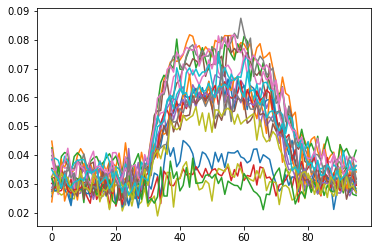

In [100]:
# Amostragem para visualizar o efeito de geração

n = 20
output_size = 96
figure = np.zeros((output_size * n))
samples_list = []

for i in range(n):
      z_sample = np.array(np.random.randn(1, output_size)) * 0.75 # 标准差取0.75而不是1
      #O desvio padrão leva 0,75 em vez de 1
      x_decoded = decoder.predict(z_sample)
      samples_list.append(x_decoded)

plt.figure()
for i in range(n):
  plt.plot(samples_list[i][0])
plt.show()